# Machine learning for Credit Card Transactions

In [1]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

In [2]:
import os
import sys

sys.path.append(f"{os.getcwd()}/..")

from utils import DATA_DIR

## Load Dataset and build graph

In [4]:
import kaggle

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi
from kaggle.api_client import ApiClient

api = KaggleApi(ApiClient())
api.authenticate()

In [6]:
api.dataset_download_cli("kartik2112/fraud-detection")

Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
License(s): CC0-1.0
fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
from zipfile import ZipFile

In [8]:
myzip = ZipFile("fraud-detection.zip")

In [9]:
tmp_file = myzip.extract("fraudTrain.csv", path=DATA_DIR)

In [10]:
myzip.close()

In [11]:
import pandas as pd
df = pd.read_csv(os.path.join(DATA_DIR, "fraudTrain.csv"))
df = df[df["is_fraud"]==0].sample(frac=0.20, random_state=42).append(df[df["is_fraud"] == 1])
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0


In [12]:
df["is_fraud"].value_counts()

0    257834
1      7506
Name: is_fraud, dtype: int64

In [13]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

In [14]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

In [15]:
G = build_graph_bipartite(df, nx.Graph())

In [16]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G)

True

## Network Analysis

In [17]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1676
Number of edges: 201725
Average degree: 240.7220


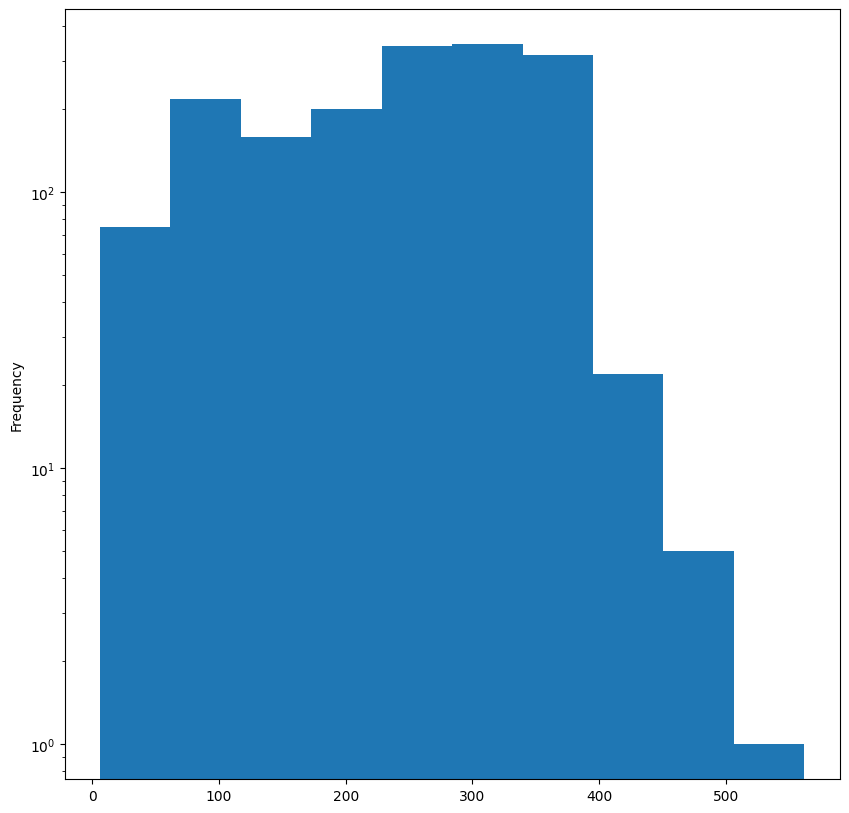

In [18]:
plt.figure(figsize=(10,10))
degrees = pd.Series({k: v for k, v in nx.degree(G)})
degrees.plot.hist()
plt.yscale("log")

In [19]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9,1.0])

array([5.030000e+00, 5.825000e+01, 9.844000e+01, 2.156560e+02,
       1.530595e+04])

In [20]:
quant_dist = np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9])
quant_dist

array([  5.03 ,  58.25 ,  98.44 , 215.656])

In [21]:
allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                     if d[2]["weight"] < quant_dist[-1]})

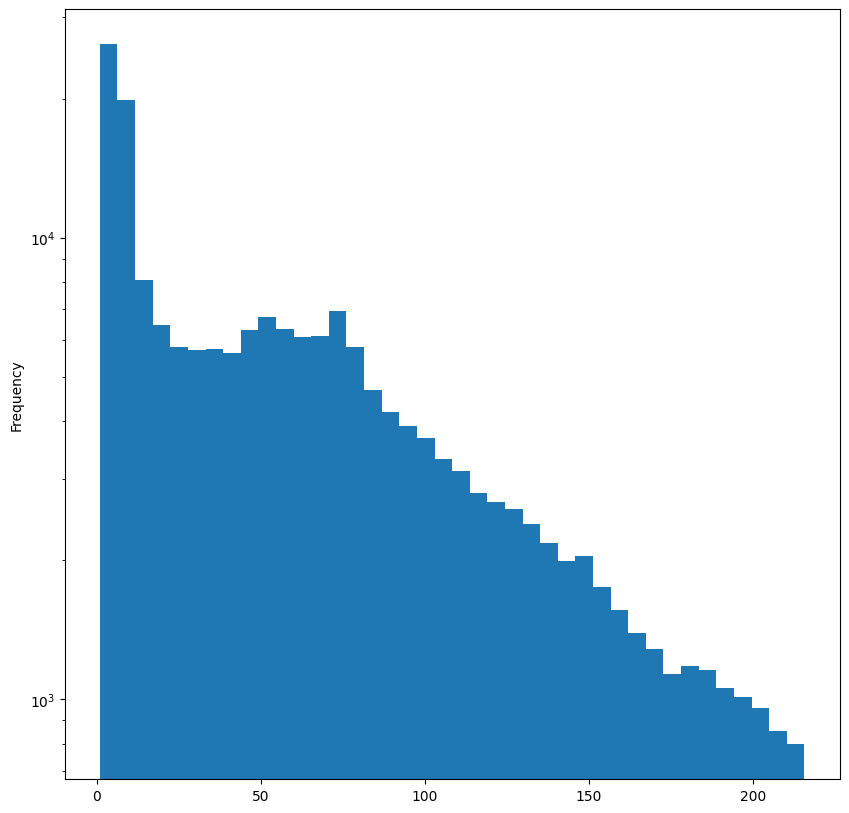

In [22]:
plt.figure(figsize=(10,10))
allEdgesWeightsFiltered.plot.hist(bins=40)
plt.yscale("log")

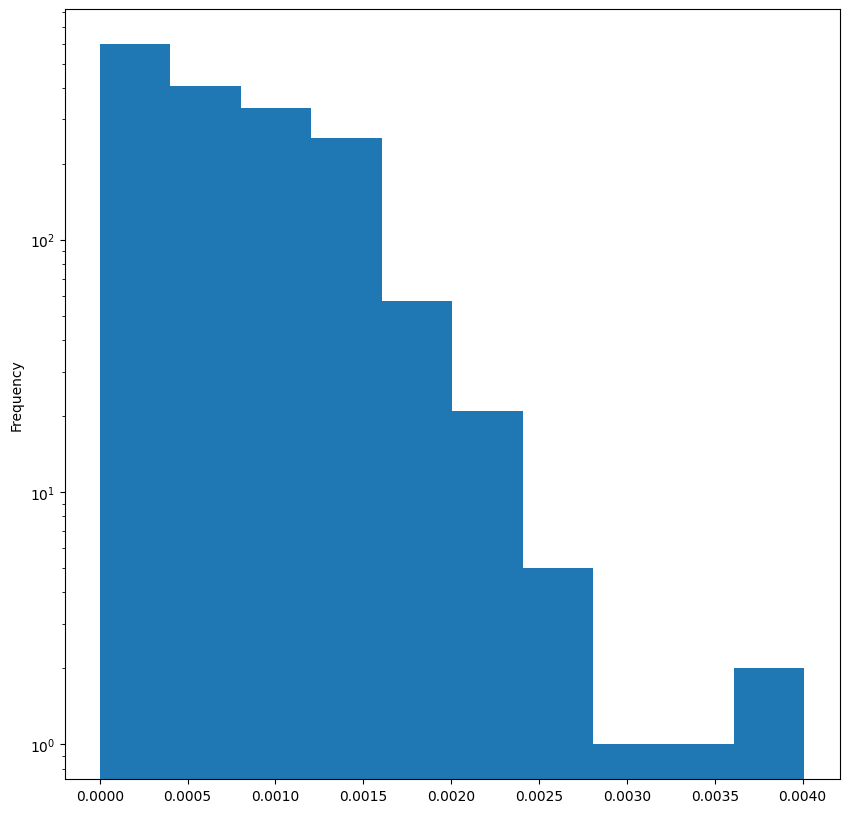

In [23]:
plt.figure(figsize=(10,10))
bC = nx.betweenness_centrality(G)
bc_distr = pd.Series(bC)
bc_distr.plot.hist()
plt.yscale("log")

In [24]:
np.mean(list(bC.values()))

0.000720547185799644

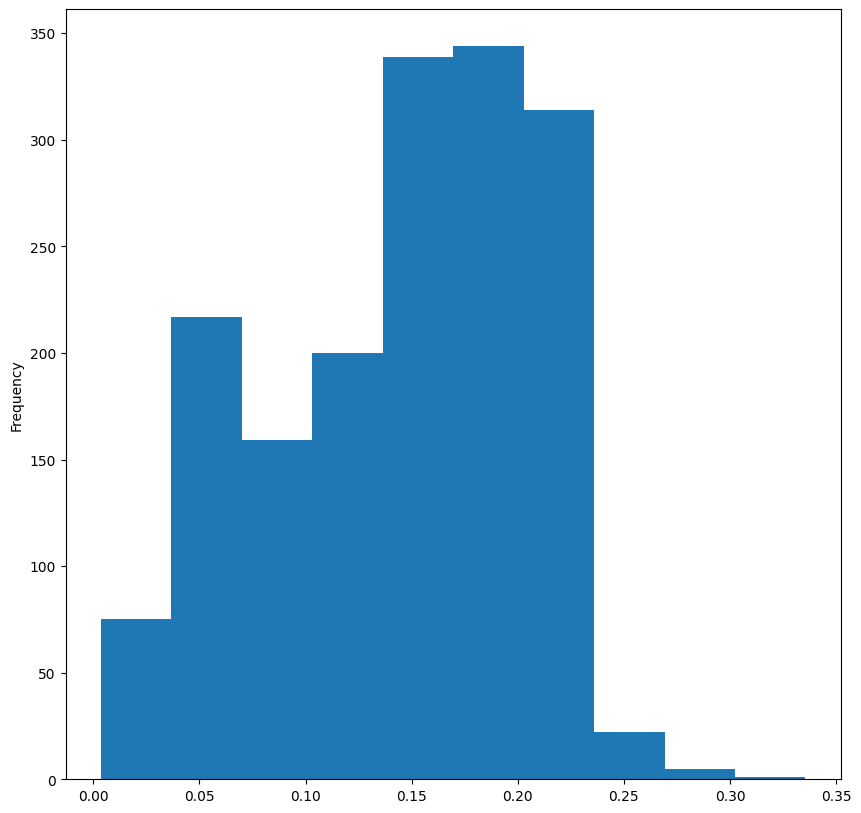

In [25]:
# degree centrality
plt.figure(figsize=(10,10))
deg_C = nx.degree_centrality(G)
degc_distr = pd.Series(deg_C)
degc_distr.plot.hist()

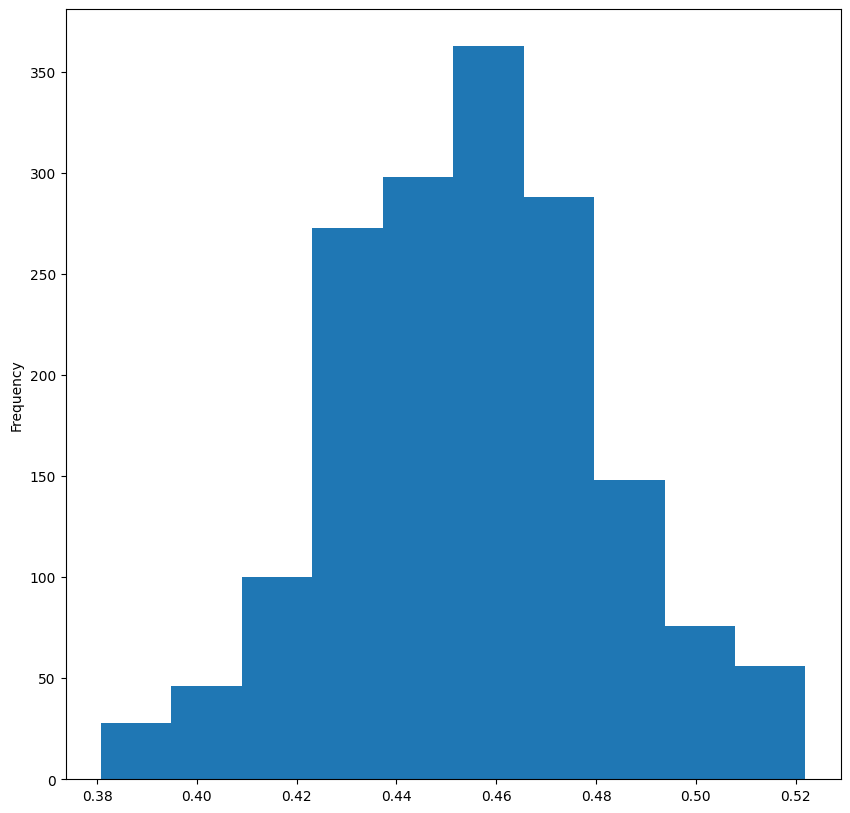

In [26]:
# closeness centrality
plt.figure(figsize=(10,10))
clos_C = nx.closeness_centrality(G)
closc_distr = pd.Series(clos_C)
closc_distr.plot.hist()

In [27]:
np.mean(list(clos_C.values()))

0.45484068767616925

In [28]:
# assortativity
nx.degree_pearson_correlation_coefficient(G)

-0.13774320410491864

### Community Detection

In [34]:
import community

parts = community.best_partition(G, random_state=42, weight='weight')

In [35]:
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

2    525
0    329
5    220
1    138
3    131
4    119
8     84
7     74
6     56
dtype: int64

In [36]:
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)

7    29.538462
6    27.272727
1    21.203438
3    20.712695
4    20.472441
8    17.484009
0     4.667955
5     1.989235
2     1.485530
dtype: float64

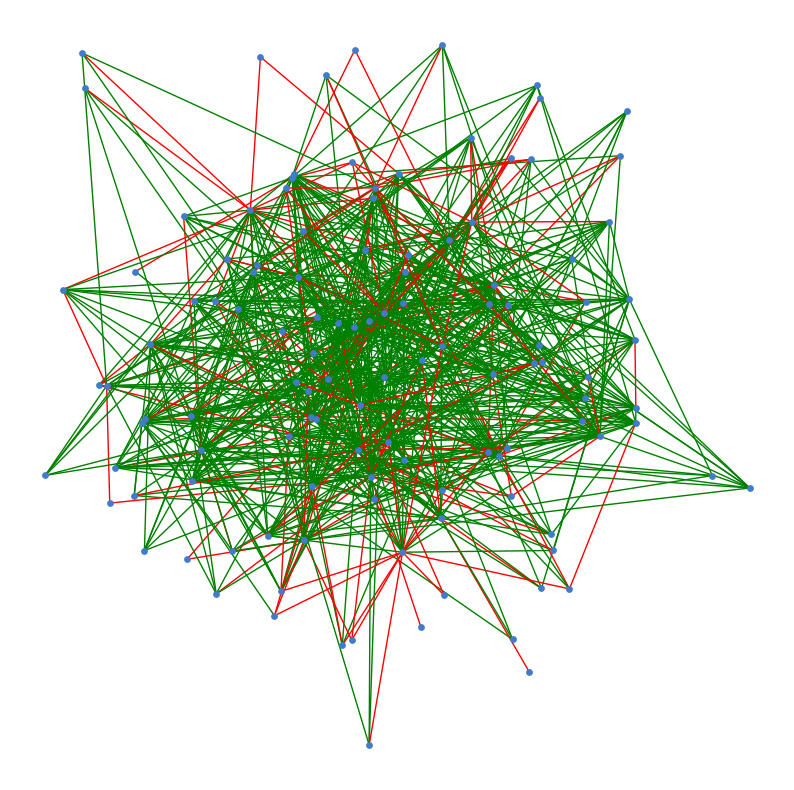

In [37]:
gId = 8
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

## Supervised Learning

In [38]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

1    7506
0    7506
Name: is_fraud, dtype: int64


In [39]:
from sklearn.model_selection import train_test_split


train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [40]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

In [41]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1): 100%|█████████████████████████████████████████| 10/10 [00:24<00:00,  2.45s/it]


In [42]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 

    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.761485826001955
Recall: 0.5221179624664879
F1-Score: 0.6194831013916501
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.7349746560463433
Recall: 0.6802949061662198
F1-Score: 0.7065784893839192
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.6103082851637764
Recall: 0.849195710455764
F1-Score: 0.7102017937219731
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.611406476558724
Recall: 0.8478552278820375
F1-Score: 0.7104745857905083


## Unupervised Learning

In [43]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

Generating walks (CPU: 1): 100%|█████████████████████████████████████████| 10/10 [00:31<00:00,  3.18s/it]


In [44]:
from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    embedding_edge = cl(keyed_vectors=unsup_vals.wv) 

    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    kmeans = KMeans(2, random_state=42).fit(embedding)
    
    
    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)
    
    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.3514455486071317
Homogeneity: 0.3395244596151279
Completeness: 0.36430541902321095
V-Measure: 0.35147868620757017
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.07245485107467836
Homogeneity: 0.071565264378958
Completeness: 0.07346200214557116
V-Measure: 0.07250123002857786
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.06077436627865752
Homogeneity: 0.060819295892827745
Completeness: 0.06082215188793648
V-Measure: 0.06082072385685444
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.050716796308473665
Homogeneity: 0.0501841306223444
Completeness: 0.05135781753703392
V-Measure: 0.05076419096690334
